In [6]:
import os
import yaml
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torchvision.utils as vutils
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from tqdm import tqdm
from torch.utils.data.dataset import Dataset
import glob
import pickle
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

%matplotlib inline
%config InlineBackend.figure_format = "retina"

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cuda


In [2]:
# Time Embedding

def get_time_embedding(T, d_model):
    factor = 10000 ** ((torch.arange(start = 0, end = d_model // 2, dtype = torch.float32, device = T.device)) / (d_model // 2))
    t_emb = T[:, None].repeat(1, d_model // 2) / factor
    t_emb = torch.cat([torch.sin(t_emb), torch.cos(t_emb)], dim = -1)
    return t_emb


# Model Blocks

class DownBlock(nn.Module):
    r"""
    Down conv block with attention.
    Sequence of following block
    1. Resnet block with time embedding
    2. Attention block
    3. Downsample
    """
    
    def __init__(self, in_channels, out_channels, t_emb_dim,
                 down_sample, num_heads, num_layers, attn, norm_channels, cross_attn=False, context_dim=None):
        super().__init__()
        self.num_layers = num_layers
        self.down_sample = down_sample
        self.attn = attn
        self.context_dim = context_dim
        self.cross_attn = cross_attn
        self.t_emb_dim = t_emb_dim
        self.resnet_conv_first = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(norm_channels, in_channels if i == 0 else out_channels),
                    nn.SiLU(),
                    nn.Conv2d(in_channels if i == 0 else out_channels, out_channels,
                              kernel_size=3, stride=1, padding=1),
                )
                for i in range(num_layers)
            ]
        )
        if self.t_emb_dim is not None:
            self.t_emb_layers = nn.ModuleList([
                nn.Sequential(
                    nn.SiLU(),
                    nn.Linear(self.t_emb_dim, out_channels)
                )
                for _ in range(num_layers)
            ])
        self.resnet_conv_second = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(norm_channels, out_channels),
                    nn.SiLU(),
                    nn.Conv2d(out_channels, out_channels,
                              kernel_size=3, stride=1, padding=1),
                )
                for _ in range(num_layers)
            ]
        )
        
        if self.attn:
            self.attention_norms = nn.ModuleList(
                [nn.GroupNorm(norm_channels, out_channels)
                 for _ in range(num_layers)]
            )
            
            self.attentions = nn.ModuleList(
                [nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
                 for _ in range(num_layers)]
            )
        
        if self.cross_attn:
            assert context_dim is not None, "Context Dimension must be passed for cross attention"
            self.cross_attention_norms = nn.ModuleList(
                [nn.GroupNorm(norm_channels, out_channels)
                 for _ in range(num_layers)]
            )
            self.cross_attentions = nn.ModuleList(
                [nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
                 for _ in range(num_layers)]
            )
            self.context_proj = nn.ModuleList(
                [nn.Linear(context_dim, out_channels)
                 for _ in range(num_layers)]
            )

        self.residual_input_conv = nn.ModuleList(
            [
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=1)
                for i in range(num_layers)
            ]
        )
        self.down_sample_conv = nn.Conv2d(out_channels, out_channels,
                                          4, 2, 1) if self.down_sample else nn.Identity()
    
    def forward(self, x, t_emb=None, context=None):
        out = x
        for i in range(self.num_layers):
            # Resnet block of Unet
            resnet_input = out
            out = self.resnet_conv_first[i](out)
            if self.t_emb_dim is not None:
                out = out + self.t_emb_layers[i](t_emb)[:, :, None, None]
            out = self.resnet_conv_second[i](out)
            out = out + self.residual_input_conv[i](resnet_input)
            
            if self.attn:
                # Attention block of Unet
                batch_size, channels, h, w = out.shape
                in_attn = out.reshape(batch_size, channels, h * w)
                in_attn = self.attention_norms[i](in_attn)
                in_attn = in_attn.transpose(1, 2)
                out_attn, _ = self.attentions[i](in_attn, in_attn, in_attn)
                out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
                out = out + out_attn
            
            if self.cross_attn:
                assert context is not None, "context cannot be None if cross attention layers are used"
                batch_size, channels, h, w = out.shape
                in_attn = out.reshape(batch_size, channels, h * w)
                in_attn = self.cross_attention_norms[i](in_attn)
                in_attn = in_attn.transpose(1, 2)
                assert context.shape[0] == x.shape[0] and context.shape[-1] == self.context_dim
                context_proj = self.context_proj[i](context)
                out_attn, _ = self.cross_attentions[i](in_attn, context_proj, context_proj)
                out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
                out = out + out_attn
            
        # Downsample
        out = self.down_sample_conv(out)
        return out


class MidBlock(nn.Module):
    r"""
    Mid conv block with attention.
    Sequence of following blocks
    1. Resnet block with time embedding
    2. Attention block
    3. Resnet block with time embedding
    """
    
    def __init__(self, in_channels, out_channels, t_emb_dim, num_heads, num_layers, norm_channels, cross_attn=None, context_dim=None):
        super().__init__()
        self.num_layers = num_layers
        self.t_emb_dim = t_emb_dim
        self.context_dim = context_dim
        self.cross_attn = cross_attn
        self.resnet_conv_first = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(norm_channels, in_channels if i == 0 else out_channels),
                    nn.SiLU(),
                    nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=3, stride=1,
                              padding=1),
                )
                for i in range(num_layers + 1)
            ]
        )
        
        if self.t_emb_dim is not None:
            self.t_emb_layers = nn.ModuleList([
                nn.Sequential(
                    nn.SiLU(),
                    nn.Linear(t_emb_dim, out_channels)
                )
                for _ in range(num_layers + 1)
            ])
        self.resnet_conv_second = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(norm_channels, out_channels),
                    nn.SiLU(),
                    nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                )
                for _ in range(num_layers + 1)
            ]
        )
        
        self.attention_norms = nn.ModuleList(
            [nn.GroupNorm(norm_channels, out_channels)
             for _ in range(num_layers)]
        )
        
        self.attentions = nn.ModuleList(
            [nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
             for _ in range(num_layers)]
        )
        if self.cross_attn:
            assert context_dim is not None, "Context Dimension must be passed for cross attention"
            self.cross_attention_norms = nn.ModuleList(
                [nn.GroupNorm(norm_channels, out_channels)
                 for _ in range(num_layers)]
            )
            self.cross_attentions = nn.ModuleList(
                [nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
                 for _ in range(num_layers)]
            )
            self.context_proj = nn.ModuleList(
                [nn.Linear(context_dim, out_channels)
                 for _ in range(num_layers)]
            )
        self.residual_input_conv = nn.ModuleList(
            [
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=1)
                for i in range(num_layers + 1)
            ]
        )
    
    def forward(self, x, t_emb=None, context=None):
        out = x
        
        # First resnet block
        resnet_input = out
        out = self.resnet_conv_first[0](out)
        if self.t_emb_dim is not None:
            out = out + self.t_emb_layers[0](t_emb)[:, :, None, None]
        out = self.resnet_conv_second[0](out)
        out = out + self.residual_input_conv[0](resnet_input)
        
        for i in range(self.num_layers):
            # Attention Block
            batch_size, channels, h, w = out.shape
            in_attn = out.reshape(batch_size, channels, h * w)
            in_attn = self.attention_norms[i](in_attn)
            in_attn = in_attn.transpose(1, 2)
            out_attn, _ = self.attentions[i](in_attn, in_attn, in_attn)
            out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
            out = out + out_attn
            
            if self.cross_attn:
                assert context is not None, "context cannot be None if cross attention layers are used"
                batch_size, channels, h, w = out.shape
                in_attn = out.reshape(batch_size, channels, h * w)
                in_attn = self.cross_attention_norms[i](in_attn)
                in_attn = in_attn.transpose(1, 2)
                assert context.shape[0] == x.shape[0] and context.shape[-1] == self.context_dim
                context_proj = self.context_proj[i](context)
                out_attn, _ = self.cross_attentions[i](in_attn, context_proj, context_proj)
                out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
                out = out + out_attn
                
            
            # Resnet Block
            resnet_input = out
            out = self.resnet_conv_first[i + 1](out)
            if self.t_emb_dim is not None:
                out = out + self.t_emb_layers[i + 1](t_emb)[:, :, None, None]
            out = self.resnet_conv_second[i + 1](out)
            out = out + self.residual_input_conv[i + 1](resnet_input)
        
        return out


class UpBlock(nn.Module):
    r"""
    Up conv block with attention.
    Sequence of following blocks
    1. Upsample
    1. Concatenate Down block output
    2. Resnet block with time embedding
    3. Attention Block
    """
    
    def __init__(self, in_channels, out_channels, t_emb_dim,
                 up_sample, num_heads, num_layers, attn, norm_channels):
        super().__init__()
        self.num_layers = num_layers
        self.up_sample = up_sample
        self.t_emb_dim = t_emb_dim
        self.attn = attn
        self.resnet_conv_first = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(norm_channels, in_channels if i == 0 else out_channels),
                    nn.SiLU(),
                    nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=3, stride=1,
                              padding=1),
                )
                for i in range(num_layers)
            ]
        )
        
        if self.t_emb_dim is not None:
            self.t_emb_layers = nn.ModuleList([
                nn.Sequential(
                    nn.SiLU(),
                    nn.Linear(t_emb_dim, out_channels)
                )
                for _ in range(num_layers)
            ])
        
        self.resnet_conv_second = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(norm_channels, out_channels),
                    nn.SiLU(),
                    nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                )
                for _ in range(num_layers)
            ]
        )
        if self.attn:
            self.attention_norms = nn.ModuleList(
                [
                    nn.GroupNorm(norm_channels, out_channels)
                    for _ in range(num_layers)
                ]
            )
            
            self.attentions = nn.ModuleList(
                [
                    nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
                    for _ in range(num_layers)
                ]
            )
            
        self.residual_input_conv = nn.ModuleList(
            [
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=1)
                for i in range(num_layers)
            ]
        )
        self.up_sample_conv = nn.ConvTranspose2d(in_channels, in_channels,
                                                 4, 2, 1) \
            if self.up_sample else nn.Identity()
    
    def forward(self, x, out_down=None, t_emb=None):
        # Upsample
        x = self.up_sample_conv(x)
        
        # Concat with Downblock output
        if out_down is not None:
            x = torch.cat([x, out_down], dim=1)
        
        out = x
        for i in range(self.num_layers):
            # Resnet Block
            resnet_input = out
            out = self.resnet_conv_first[i](out)
            if self.t_emb_dim is not None:
                out = out + self.t_emb_layers[i](t_emb)[:, :, None, None]
            out = self.resnet_conv_second[i](out)
            out = out + self.residual_input_conv[i](resnet_input)
            
            # Self Attention
            if self.attn:
                batch_size, channels, h, w = out.shape
                in_attn = out.reshape(batch_size, channels, h * w)
                in_attn = self.attention_norms[i](in_attn)
                in_attn = in_attn.transpose(1, 2)
                out_attn, _ = self.attentions[i](in_attn, in_attn, in_attn)
                out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
                out = out + out_attn
        return out


class UpBlockUnet(nn.Module):
    r"""
    Up conv block with attention.
    Sequence of following blocks
    1. Upsample
    1. Concatenate Down block output
    2. Resnet block with time embedding
    3. Attention Block
    """
    
    def __init__(self, in_channels, out_channels, t_emb_dim, up_sample,
                 num_heads, num_layers, norm_channels, cross_attn=False, context_dim=None):
        super().__init__()
        self.num_layers = num_layers
        self.up_sample = up_sample
        self.t_emb_dim = t_emb_dim
        self.cross_attn = cross_attn
        self.context_dim = context_dim
        self.resnet_conv_first = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(norm_channels, in_channels if i == 0 else out_channels),
                    nn.SiLU(),
                    nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=3, stride=1,
                              padding=1),
                )
                for i in range(num_layers)
            ]
        )
        
        if self.t_emb_dim is not None:
            self.t_emb_layers = nn.ModuleList([
                nn.Sequential(
                    nn.SiLU(),
                    nn.Linear(t_emb_dim, out_channels)
                )
                for _ in range(num_layers)
            ])
            
        self.resnet_conv_second = nn.ModuleList(
            [
                nn.Sequential(
                    nn.GroupNorm(norm_channels, out_channels),
                    nn.SiLU(),
                    nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                )
                for _ in range(num_layers)
            ]
        )
        
        self.attention_norms = nn.ModuleList(
            [
                nn.GroupNorm(norm_channels, out_channels)
                for _ in range(num_layers)
            ]
        )
        
        self.attentions = nn.ModuleList(
            [
                nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
                for _ in range(num_layers)
            ]
        )
        
        if self.cross_attn:
            assert context_dim is not None, "Context Dimension must be passed for cross attention"
            self.cross_attention_norms = nn.ModuleList(
                [nn.GroupNorm(norm_channels, out_channels)
                 for _ in range(num_layers)]
            )
            self.cross_attentions = nn.ModuleList(
                [nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
                 for _ in range(num_layers)]
            )
            self.context_proj = nn.ModuleList(
                [nn.Linear(context_dim, out_channels)
                 for _ in range(num_layers)]
            )
        self.residual_input_conv = nn.ModuleList(
            [
                nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size=1)
                for i in range(num_layers)
            ]
        )
        self.up_sample_conv = nn.ConvTranspose2d(in_channels // 2, in_channels // 2,
                                                 4, 2, 1) \
            if self.up_sample else nn.Identity()
    
    def forward(self, x, out_down=None, t_emb=None, context=None):
        x = self.up_sample_conv(x)
        if out_down is not None:
            x = torch.cat([x, out_down], dim=1)
        
        out = x
        for i in range(self.num_layers):
            # Resnet
            resnet_input = out
            out = self.resnet_conv_first[i](out)
            if self.t_emb_dim is not None:
                out = out + self.t_emb_layers[i](t_emb)[:, :, None, None]
            out = self.resnet_conv_second[i](out)
            out = out + self.residual_input_conv[i](resnet_input)
            # Self Attention
            batch_size, channels, h, w = out.shape
            in_attn = out.reshape(batch_size, channels, h * w)
            in_attn = self.attention_norms[i](in_attn)
            in_attn = in_attn.transpose(1, 2)
            out_attn, _ = self.attentions[i](in_attn, in_attn, in_attn)
            out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
            out = out + out_attn
            # Cross Attention
            if self.cross_attn:
                assert context is not None, "context cannot be None if cross attention layers are used"
                batch_size, channels, h, w = out.shape
                in_attn = out.reshape(batch_size, channels, h * w)
                in_attn = self.cross_attention_norms[i](in_attn)
                in_attn = in_attn.transpose(1, 2)
                assert len(context.shape) == 3, \
                    "Context shape does not match B,_,CONTEXT_DIM"
                assert context.shape[0] == x.shape[0] and context.shape[-1] == self.context_dim,\
                    "Context shape does not match B,_,CONTEXT_DIM"
                context_proj = self.context_proj[i](context)
                out_attn, _ = self.cross_attentions[i](in_attn, context_proj, context_proj)
                out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
                out = out + out_attn
        
        return out

In [3]:
class VQVAE(nn.Module):
    def __init__(self):
        super().__init__()
        im_channels = 3
        self.down_channels = [64, 128, 256, 256]
        self.mid_channels = [256, 256]
        self.down_sample = [True, True, True]
        self.num_down_layers = 2
        self.num_mid_layers = 2
        self.num_up_layers = 2
        self.norm_channels = 32
        
        # To disable attention in the DownBlock of Encoder and UpBlock of Decoder
        self.attns = [False, False, False]
        self.num_heads = 4
        
        # Latent Dimension
        self.z_channels = 3
        self.codebook_size = 8192
        
        # Wherever we use downsampling in encoder correspondingly use
        # upsampling in decoder
        self.up_sample = list(reversed(self.down_sample))
        
        ##################### Encoder ######################
        self.encoder_conv_in = nn.Conv2d(im_channels, self.down_channels[0], kernel_size=3, padding=(1, 1))
        
        # Downblock + Midblock
        self.encoder_layers = nn.ModuleList([])
        for i in range(len(self.down_channels) - 1):
            self.encoder_layers.append(DownBlock(self.down_channels[i], self.down_channels[i + 1],
                                                 t_emb_dim=None, down_sample=self.down_sample[i],
                                                 num_heads=self.num_heads,
                                                 num_layers=self.num_down_layers,
                                                 attn=self.attns[i],
                                                 norm_channels=self.norm_channels))
        
        self.encoder_mids = nn.ModuleList([])
        for i in range(len(self.mid_channels) - 1):
            self.encoder_mids.append(MidBlock(self.mid_channels[i], self.mid_channels[i + 1],
                                              t_emb_dim=None,
                                              num_heads=self.num_heads,
                                              num_layers=self.num_mid_layers,
                                              norm_channels=self.norm_channels))
        
        self.encoder_norm_out = nn.GroupNorm(self.norm_channels, self.down_channels[-1])
        self.encoder_conv_out = nn.Conv2d(self.down_channels[-1], self.z_channels, kernel_size=3, padding=1)
        
        # Pre Quantization Convolution
        self.pre_quant_conv = nn.Conv2d(self.z_channels, self.z_channels, kernel_size=1)
        
        # Codebook
        self.embedding = nn.Embedding(self.codebook_size, self.z_channels)
        ####################################################
        
        ##################### Decoder ######################
        
        # Post Quantization Convolution
        self.post_quant_conv = nn.Conv2d(self.z_channels, self.z_channels, kernel_size=1)
        self.decoder_conv_in = nn.Conv2d(self.z_channels, self.mid_channels[-1], kernel_size=3, padding=(1, 1))
        
        # Midblock + Upblock
        self.decoder_mids = nn.ModuleList([])
        for i in reversed(range(1, len(self.mid_channels))):
            self.decoder_mids.append(MidBlock(self.mid_channels[i], self.mid_channels[i - 1],
                                              t_emb_dim=None,
                                              num_heads=self.num_heads,
                                              num_layers=self.num_mid_layers,
                                              norm_channels=self.norm_channels))
        
        self.decoder_layers = nn.ModuleList([])
        for i in reversed(range(1, len(self.down_channels))):
            self.decoder_layers.append(UpBlock(self.down_channels[i], self.down_channels[i - 1],
                                               t_emb_dim=None, up_sample=self.down_sample[i - 1],
                                               num_heads=self.num_heads,
                                               num_layers=self.num_up_layers,
                                               attn=self.attns[i-1],
                                               norm_channels=self.norm_channels))
        
        self.decoder_norm_out = nn.GroupNorm(self.norm_channels, self.down_channels[0])
        self.decoder_conv_out = nn.Conv2d(self.down_channels[0], im_channels, kernel_size=3, padding=1)
    
    def quantize(self, x):
        B, C, H, W = x.shape
        
        # B, C, H, W -> B, H, W, C
        x = x.permute(0, 2, 3, 1)
        
        # B, H, W, C -> B, H*W, C
        x = x.reshape(x.size(0), -1, x.size(-1))
        
        # Find nearest embedding/codebook vector
        # dist between (B, H*W, C) and (B, K, C) -> (B, H*W, K)
        dist = torch.cdist(x, self.embedding.weight[None, :].repeat((x.size(0), 1, 1)))
        # (B, H*W)
        min_encoding_indices = torch.argmin(dist, dim=-1)
        
        # Replace encoder output with nearest codebook
        # quant_out -> B*H*W, C
        quant_out = torch.index_select(self.embedding.weight, 0, min_encoding_indices.view(-1))
        
        # x -> B*H*W, C
        x = x.reshape((-1, x.size(-1)))
        commmitment_loss = torch.mean((quant_out.detach() - x) ** 2)
        codebook_loss = torch.mean((quant_out - x.detach()) ** 2)
        quantize_losses = {
            'codebook_loss': codebook_loss,
            'commitment_loss': commmitment_loss
        }
        # Straight through estimation
        quant_out = x + (quant_out - x).detach()
        
        # quant_out -> B, C, H, W
        quant_out = quant_out.reshape((B, H, W, C)).permute(0, 3, 1, 2)
        min_encoding_indices = min_encoding_indices.reshape((-1, quant_out.size(-2), quant_out.size(-1)))
        return quant_out, quantize_losses, min_encoding_indices

    def encode(self, x):
        out = self.encoder_conv_in(x)
        for idx, down in enumerate(self.encoder_layers):
            out = down(out)
        for mid in self.encoder_mids:
            out = mid(out)
        out = self.encoder_norm_out(out)
        out = nn.SiLU()(out)
        out = self.encoder_conv_out(out)
        out = self.pre_quant_conv(out)
        out, quant_losses, _ = self.quantize(out)
        return out, quant_losses
    
    def decode(self, z):
        out = z
        out = self.post_quant_conv(out)
        out = self.decoder_conv_in(out)
        for mid in self.decoder_mids:
            out = mid(out)
        for idx, up in enumerate(self.decoder_layers):
            out = up(out)
        
        out = self.decoder_norm_out(out)
        out = nn.SiLU()(out)
        out = self.decoder_conv_out(out)
        return out
    
    def forward(self, x):
        z, quant_losses = self.encode(x)
        out = self.decode(z)
        return out, z, quant_losses

## Loading Dataset

In [79]:
def load_latents(latent_path):
    r"""
    Simple utility to save latents to speed up ldm training
    :param latent_path:
    :return:
    """
    latent_maps = {}
    for fname in glob.glob(os.path.join(latent_path, '*.pkl')):
        s = pickle.load(open(fname, 'rb'))
        for k, v in s.items():
            latent_maps[k] = v[0]
    return latent_maps

class CelebDataset(Dataset):
    r"""
    Celeb dataset will by default centre crop and resize the images.
    This can be replaced by any other dataset. As long as all the images
    are under one directory.
    """
    
    def __init__(self, split, im_path, im_size=256, im_channels=3, im_ext='jpg',
                 use_latents=False, latent_path=None, condition_config=None):
        self.split = split
        self.im_size = im_size
        self.im_channels = im_channels
        self.im_ext = im_ext
        self.im_path = im_path
        self.latent_maps = None
        self.use_latents = False
        
        self.condition_types = [] if condition_config is None else condition_config['condition_types']
        
        self.idx_to_cls_map = {}
        self.cls_to_idx_map ={}
        
        if 'image' in self.condition_types:
            # self.mask_channels = condition_config['image_condition_config']['image_condition_input_channels']
            self.mask_channels = 1
            self.mask_h = condition_config['image_condition_config']['image_condition_h']
            self.mask_w = condition_config['image_condition_config']['image_condition_w']
            
        self.images, self.texts, self.masks = self.load_images(im_path)
        
        # Whether to load images or to load latents
        if use_latents and latent_path is not None:
            latent_maps = load_latents(latent_path)
            if len(latent_maps) == len(self.images):
                self.use_latents = True
                self.latent_maps = latent_maps
                print('Found {} latents'.format(len(self.latent_maps)))
            else:
                print('Latents not found')
    
    def load_images(self, im_path):
        r"""
        Gets all images from the path specified
        and stacks them all up
        """
        assert os.path.exists(im_path), "images path {} does not exist".format(im_path)
        ims = []
        fnames = glob.glob(os.path.join(im_path, 'CelebA-HQ-img/*.{}'.format('png')))
        fnames += glob.glob(os.path.join(im_path, 'CelebA-HQ-img/*.{}'.format('jpg')))
        fnames += glob.glob(os.path.join(im_path, 'CelebA-HQ-img/*.{}'.format('jpeg')))
        texts = []
        masks = []
        
        if 'image' in self.condition_types:
            label_list = ['skin', 'nose', 'eye_g', 'l_eye', 'r_eye', 'l_brow', 'r_brow', 'l_ear', 'r_ear', 'mouth',
                          'u_lip', 'l_lip', 'hair', 'hat', 'ear_r', 'neck_l', 'neck', 'cloth']
            # label_list = ['hair']
            self.idx_to_cls_map = {idx: label_list[idx] for idx in range(len(label_list))}
            self.cls_to_idx_map = {label_list[idx]: idx for idx in range(len(label_list))}
            # self.idx_to_cls_map = {12: 'hair'}
            # self.cls_to_idx_map = {'hair': 12}
        
        for fname in tqdm(fnames):
            ims.append(fname)
            
            if 'text' in self.condition_types:
                im_name = os.path.split(fname)[1].split('.')[0]
                captions_im = []
                with open(os.path.join(im_path, 'celeba-caption/{}.txt'.format(im_name))) as f:
                    for line in f.readlines():
                        captions_im.append(line.strip())
                texts.append(captions_im)
                
            if 'image' in self.condition_types:
                im_name = int(os.path.split(fname)[1].split('.')[0])
                masks.append(os.path.join(im_path, 'CelebAMask-HQ-mask', '{}.png'.format(im_name)))
        if 'text' in self.condition_types:
            assert len(texts) == len(ims), "Condition Type Text but could not find captions for all images"
        if 'image' in self.condition_types:
            assert len(masks) == len(ims), "Condition Type Image but could not find masks for all images"
        print('Found {} images'.format(len(ims)))
        print('Found {} masks'.format(len(masks)))
        print('Found {} captions'.format(len(texts)))
        return ims, texts, masks
    
    def get_mask(self, index):
        r"""
        Method to get the mask of WxH
        for given index and convert it into
        Classes x W x H mask image
        :param index:
        :return:
        """
        mask_im = Image.open(self.masks[index])
        # print(mask_im.shape)
        mask_im = np.array(mask_im)
        im_base = np.zeros((self.mask_h, self.mask_w, self.mask_channels))
        for orig_idx in range(len(self.idx_to_cls_map)):
            # im_base[mask_im == (orig_idx+1), orig_idx] = 1
            im_base[mask_im == 13, 0] = 1
            # im_base[mask_im == 10, 9] = 1
        mask = torch.from_numpy(im_base).permute(2, 0, 1).float()
        return mask
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        ######## Set Conditioning Info ########
        cond_inputs = {}
        if 'text' in self.condition_types:
            cond_inputs['text'] = random.sample(self.texts[index], k=1)[0]
        if 'image' in self.condition_types:
            mask = self.get_mask(index)
            cond_inputs['image'] = mask
        #######################################
        
        if self.use_latents:
            latent = self.latent_maps[self.images[index]]
            if len(self.condition_types) == 0:
                return latent
            else:
                return latent, cond_inputs
        else:
            im = Image.open(self.images[index])
            im_tensor = transforms.Compose([
                transforms.Resize(self.im_size),
                transforms.CenterCrop(self.im_size),
                transforms.ToTensor(),
            ])(im)
            im.close()
        
            # Convert input to -1 to 1 range.
            im_tensor = (2 * im_tensor) - 1
            if len(self.condition_types) == 0:
                return im_tensor
            else:
                return im_tensor, cond_inputs

In [76]:
batch_size_autoenc = 8
batch_size_ldm = 16
# Model Parameters
nc = 3
image_size = 256

### Loading Config

In [80]:
def get_config_value(config, key, default_value):
    return config[key] if key in config else default_value

config_path = "../celebhq_cond.yaml"
with open(config_path, 'r') as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)

diffusion_model_config = config['ldm_params']
condition_config = get_config_value(diffusion_model_config, key='condition_config', default_value=None)

In [50]:
path = "../CelebAMask-HQ"

im_dataset = CelebDataset(split='train',
                                im_path=path,
                                im_size=image_size,
                                im_channels=nc,
                                use_latents=True,
                                latent_path="../vqvaelatents",
                                condition_config=condition_config)
    
celebAloader = DataLoader(im_dataset,
                            batch_size=batch_size_ldm,
                            shuffle=True)

100%|██████████| 30000/30000 [00:00<00:00, 46834.27it/s]


Found 30000 images
Found 30000 masks
Found 30000 captions
Found 30000 latents


In [81]:
path = "../CelebAMask-HQ"

im_dataset = CelebDataset(split='train',
                                im_path=path,
                                im_size=image_size,
                                im_channels=nc,
                                use_latents=False,
                                latent_path="../vqvaelatents",
                                condition_config=condition_config)
    
celebAloader = DataLoader(im_dataset,
                            batch_size=batch_size_ldm,
                            shuffle=True)

100%|██████████| 30000/30000 [00:00<00:00, 68542.78it/s]

Found 30000 images
Found 30000 masks
Found 30000 captions


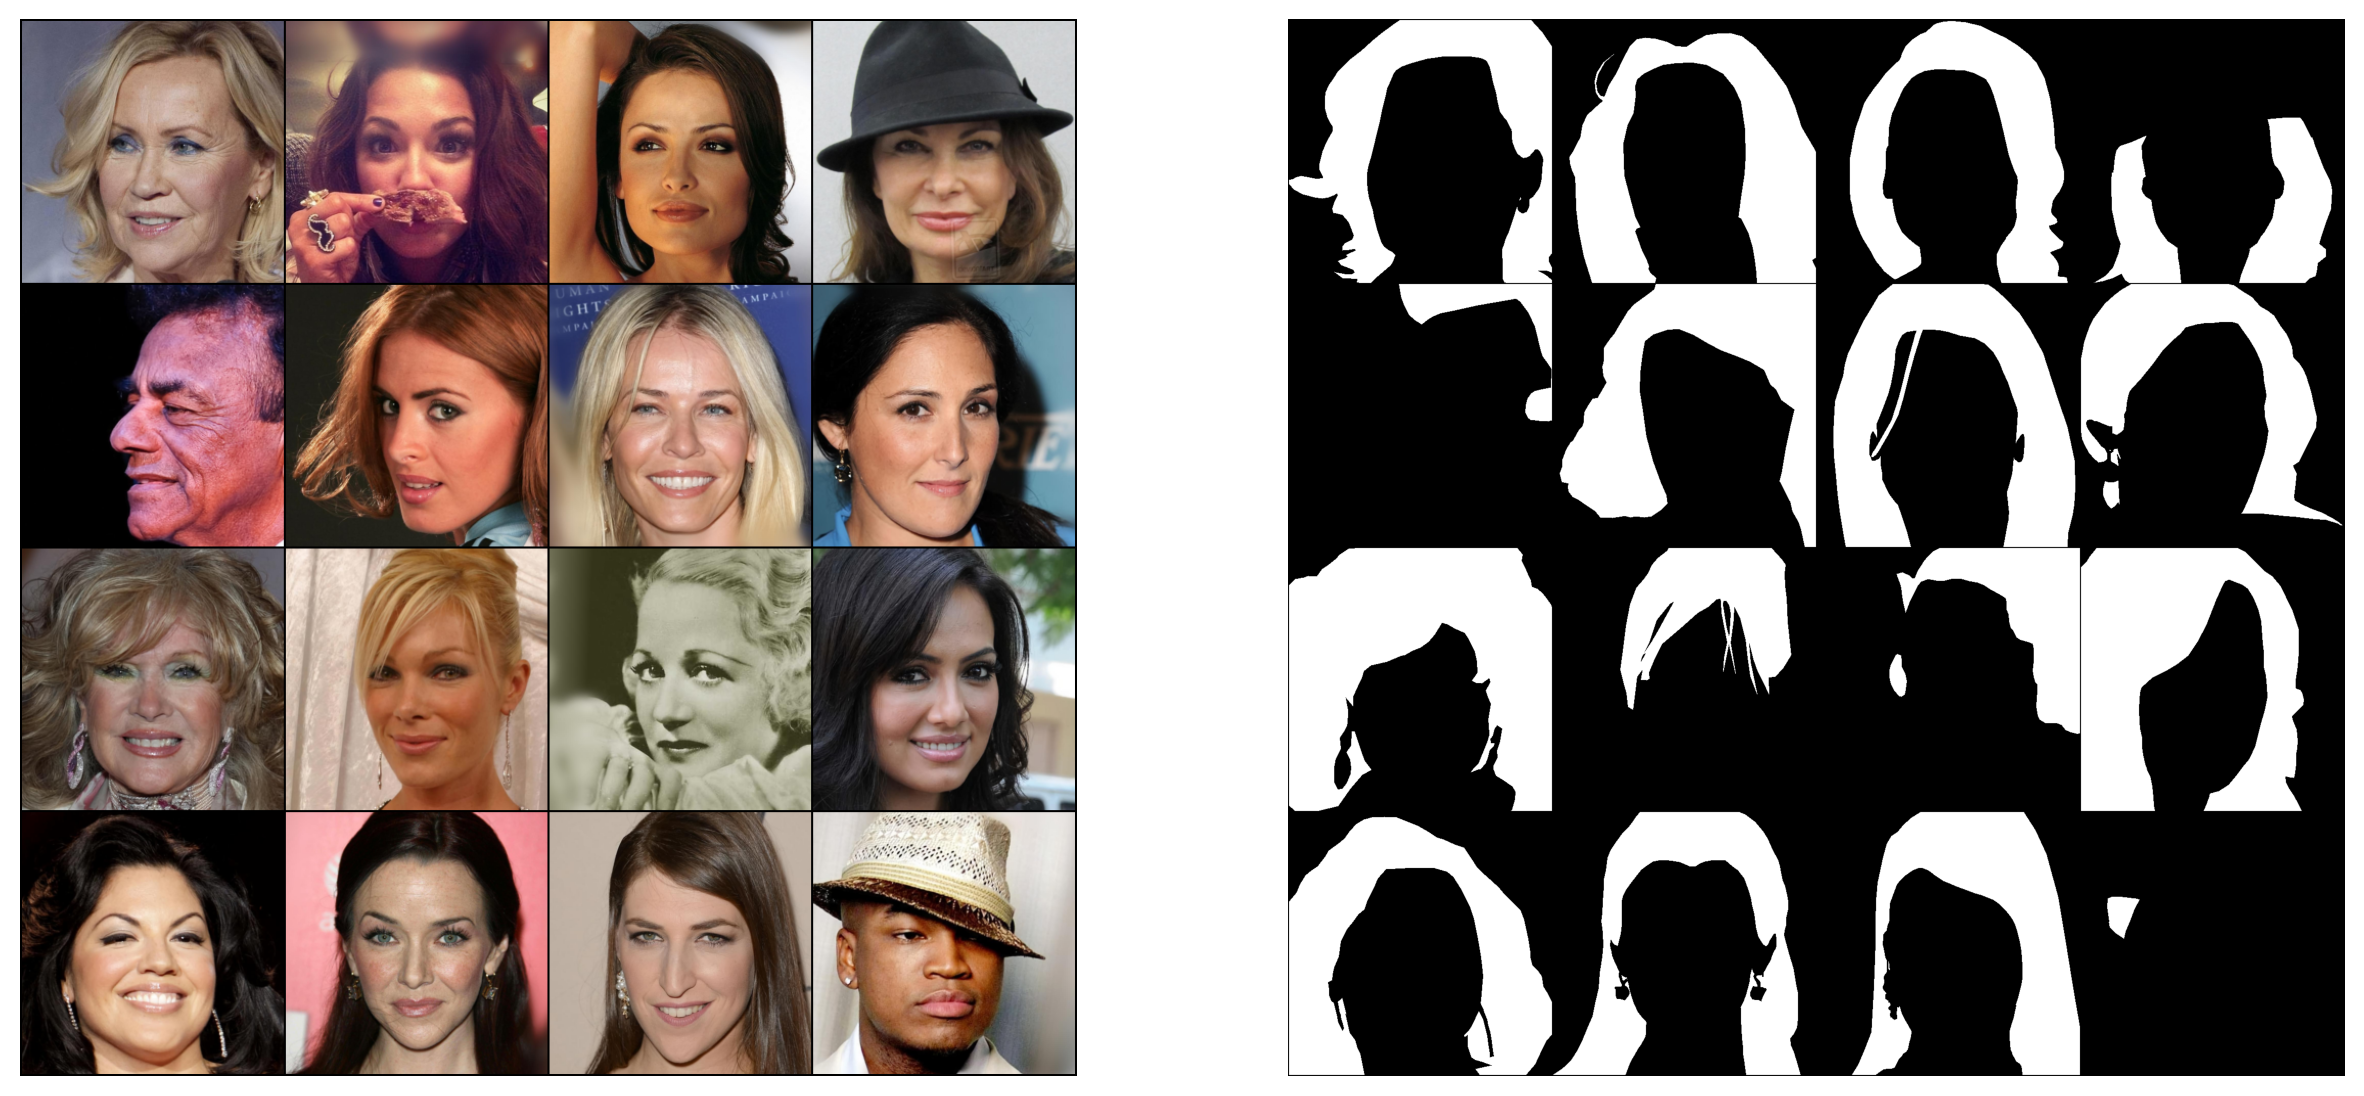

In [83]:
indices = np.random.choice(30000, 16, replace = False)
images = torch.stack([im_dataset[i][0] for i in indices], dim = 0)
mask = torch.stack([im_dataset[i][1]["image"] for i in indices], dim = 0)
grid = vutils.make_grid(images, nrow = 4, normalize = True)
grid1 = vutils.make_grid(mask, nrow = 4, normalize = True)
plt.figure(figsize = (15, 8))
plt.subplot(1, 2, 1)
plt.imshow(np.transpose(grid, (1, 2, 0)))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(np.transpose(grid1, (1, 2, 0)))
plt.axis('off')
plt.show()

In [82]:
print(im_dataset[0][1]["image"].shape)
print(im_dataset[0][0].shape)

torch.Size([1, 512, 512])
torch.Size([3, 256, 256])


In [84]:
model = VQVAE().to(device)
model.load_state_dict(torch.load("../vqvaeCeleb/vqvae_autoencoder.pth", map_location = device))
model.eval()

VQVAE(
  (encoder_conv_in): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_layers): ModuleList(
    (0): DownBlock(
      (resnet_conv_first): ModuleList(
        (0): Sequential(
          (0): GroupNorm(32, 64, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1): Sequential(
          (0): GroupNorm(32, 128, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
      (resnet_conv_second): ModuleList(
        (0-1): 2 x Sequential(
          (0): GroupNorm(32, 128, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
      (residual_input_conv): ModuleList(
        (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
        (1): Conv2d(128, 128, kernel_size=(1, 1), stride=

In [85]:
im = model.encode(images.to(device))[0]

OutOfMemoryError: CUDA out of memory. Tried to allocate 512.00 MiB. GPU 

In [38]:
im.shape

torch.Size([16, 3, 32, 32])

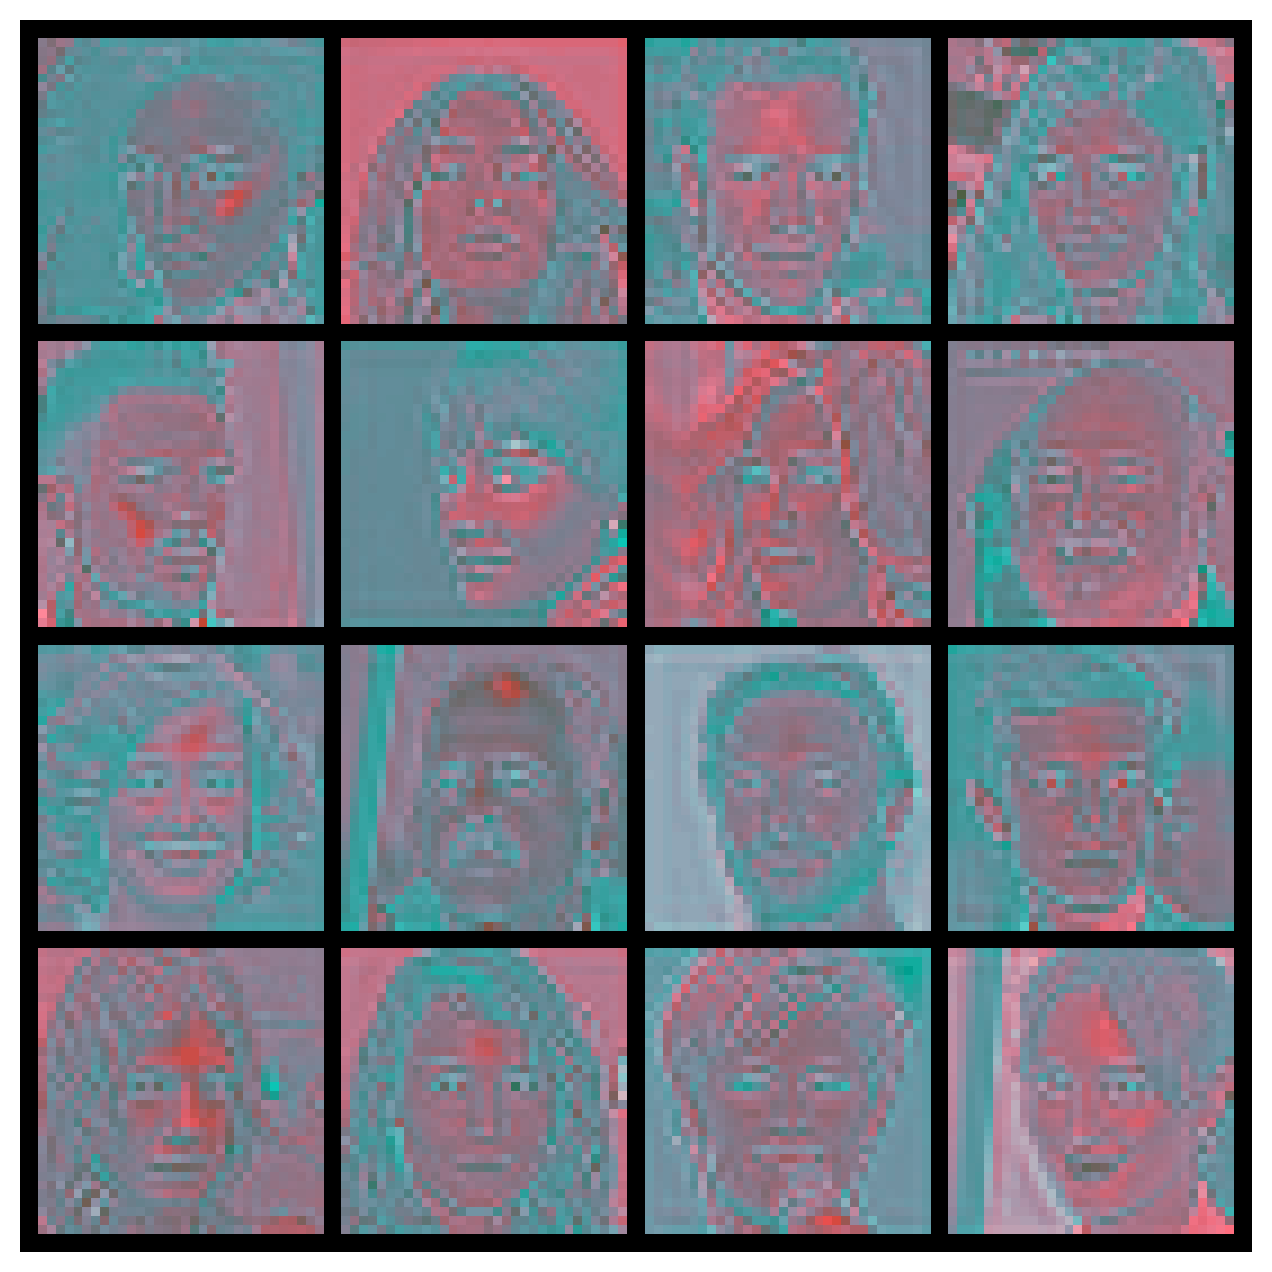

In [40]:
grid2 = vutils.make_grid(im, nrow = 4, normalize = True)
plt.figure(figsize = (8, 8))
plt.imshow(np.transpose(grid2.cpu().detach().numpy(), (1, 2, 0)))
plt.axis('off')
plt.show()

## UNet

In [ ]:
class Unet(nn.Module):
    def __init__(self, im_channels = 3):
        super().__init__()
        self.down_channels = [256, 384, 512, 768]
        self.mid_channels = [768, 512]
        self.t_emb_dim = 512
        self.down_sample = [True, True, True]
        self.num_down_layers = 2
        self.num_mid_layers = 2
        self.num_up_layers = 2
        self.attns = [True, True, True]
        self.norm_channels = 32
        self.num_heads = 16
        self.conv_out_channels = 128
        
        # Initial projection from sinusoidal time embedding
        
        self.t_proj = nn.Sequential(
            nn.Linear(self.t_emb_dim, self.t_emb_dim),
            nn.SiLU(),
            nn.Linear(self.t_emb_dim, self.t_emb_dim)
        )
        
        self.up_sample = list(reversed(self.down_sample))
        self.conv_in = nn.Conv2d(im_channels, self.down_channels[0], kernel_size = 3, padding = 1)
        
        self.downs = nn.ModuleList([])
        for i in range(len(self.down_channels) - 1):
            self.downs.append(DownBlock(self.down_channels[i], self.down_channels[i + 1],
                                       t_emb_dim = self.t_emb_dim, down_sample = self.down_sample[i],
                                       num_heads = self.num_heads, num_layers = self.num_down_layers,
                                       attn = self.attns[i], norm_channels = self.norm_channels))
        
        self.mids = nn.ModuleList([])
        for i in range(len(self.mid_channels) - 1):
            self.mids.append(MidBlock(self.mid_channels[i], self.mid_channels[i + 1],
                                    t_emb_dim = self.t_emb_dim, num_heads = self.num_heads,
                                    num_layers = self.num_mid_layers, norm_channels = self.norm_channels))
        
        self.ups = nn.ModuleList([])
        for i in reversed(range(len(self.down_channels) - 1)):
            self.ups.append(UpBlockUnet(self.down_channels[i] * 2, self.down_channels[i - 1] if i != 0 else self.conv_out_channels,
                                    self.t_emb_dim, up_sample = self.down_sample[i],
                                        num_heads = self.num_heads,
                                        num_layers = self.num_up_layers,
                                        norm_channels = self.norm_channels))
        
        self.norm_out = nn.GroupNorm(self.norm_channels, self.conv_out_channels)
        self.conv_out = nn.Conv2d(self.conv_out_channels, im_channels, kernel_size = 3, padding = 1)
        
    def forward(self, x, t):
        # Shapes assuming downblocks are [C1, C2, C3, C4]
        # Shapes assuming midblocks are [C4, C4, C3]
        # Shapes assuming downsamples are [True, True, False]
        # B x C x H x W
        out = self.conv_in(x)
        # B x C1 x H x W
        
        # t_emb -> B x t_emb_dim
        t_emb = get_time_embedding(torch.as_tensor(t).long(), self.t_emb_dim)
        t_emb = self.t_proj(t_emb)
        
        down_outs = []
        
        for idx, down in enumerate(self.downs):
            down_outs.append(out)
            out = down(out, t_emb)
        # down_outs  [B x C1 x H x W, B x C2 x H/2 x W/2, B x C3 x H/4 x W/4]
        # out B x C4 x H/4 x W/4
        
        for mid in self.mids:
            out = mid(out, t_emb)
        # out B x C3 x H/4 x W/4
        
        for up in self.ups:
            down_out = down_outs.pop()
            out = up(out, down_out, t_emb)
            # out [B x C2 x H/4 x W/4, B x C1 x H/2 x W/2, B x 16 x H x W]
        out = self.norm_out(out)
        out = nn.SiLU()(out)
        out = self.conv_out(out)
        # out B x C x H x W
        return out

## Noise Scheduler

In [ ]:
class LinearNoiseScheduler:
    r"""
    Class for the linear noise scheduler that is used in DDPM.
    """
    
    def __init__(self, num_timesteps, beta_start, beta_end):
        self.num_timesteps = num_timesteps
        self.beta_start = beta_start
        self.beta_end = beta_end
        # Mimicking how compvis repo creates schedule
        self.betas = (
                torch.linspace(beta_start ** 0.5, beta_end ** 0.5, num_timesteps) ** 2
        )
        self.alphas = 1. - self.betas
        self.alpha_cum_prod = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alpha_cum_prod = torch.sqrt(self.alpha_cum_prod)
        self.sqrt_one_minus_alpha_cum_prod = torch.sqrt(1 - self.alpha_cum_prod)
    
    def add_noise(self, original, noise, t):
        r"""
        Forward method for diffusion
        :param original: Image on which noise is to be applied
        :param noise: Random Noise Tensor (from normal dist)
        :param t: timestep of the forward process of shape -> (B,)
        :return:
        """
        original_shape = original.shape
        batch_size = original_shape[0]
        
        sqrt_alpha_cum_prod = self.sqrt_alpha_cum_prod.to(original.device)[t].reshape(batch_size)
        sqrt_one_minus_alpha_cum_prod = self.sqrt_one_minus_alpha_cum_prod.to(original.device)[t].reshape(batch_size)
        
        # Reshape till (B,) becomes (B,1,1,1) if image is (B,C,H,W)
        for _ in range(len(original_shape) - 1):
            sqrt_alpha_cum_prod = sqrt_alpha_cum_prod.unsqueeze(-1)
        for _ in range(len(original_shape) - 1):
            sqrt_one_minus_alpha_cum_prod = sqrt_one_minus_alpha_cum_prod.unsqueeze(-1)
        
        # Apply and Return Forward process equation
        return (sqrt_alpha_cum_prod.to(original.device) * original
                + sqrt_one_minus_alpha_cum_prod.to(original.device) * noise)
    
    def sample_prev_timestep(self, xt, noise_pred, t):
        r"""
            Use the noise prediction by model to get
            xt-1 using xt and the nosie predicted
        :param xt: current timestep sample
        :param noise_pred: model noise prediction
        :param t: current timestep we are at
        :return:
        """
        x0 = ((xt - (self.sqrt_one_minus_alpha_cum_prod.to(xt.device)[t] * noise_pred)) /
              torch.sqrt(self.alpha_cum_prod.to(xt.device)[t]))
        x0 = torch.clamp(x0, -1., 1.)
        
        mean = xt - ((self.betas.to(xt.device)[t]) * noise_pred) / (self.sqrt_one_minus_alpha_cum_prod.to(xt.device)[t])
        mean = mean / torch.sqrt(self.alphas.to(xt.device)[t])
        
        if t == 0:
            return mean, x0
        else:
            variance = (1 - self.alpha_cum_prod.to(xt.device)[t - 1]) / (1.0 - self.alpha_cum_prod.to(xt.device)[t])
            variance = variance * self.betas.to(xt.device)[t]
            sigma = variance ** 0.5
            z = torch.randn(xt.shape).to(xt.device)
            return mean + sigma * z, x0

In [ ]:
scheduler = LinearNoiseScheduler(T, beta_start, beta_end)

model = Unet(im_channels = z_channels).to(device)
model.load_state_dict(torch.load("../ldmCeleb/denoiseLatentModelCeleb.pth", map_location = device))
model.eval()

vae = VQVAE().to(device)
vae.eval()
vae.load_state_dict(torch.load("../vqvaeCeleb/vqvae_autoencoder.pth", map_location=device), strict=True)

with torch.no_grad():
    im_size = image_size // (2 ** (sum(model.down_sample)))
    xt = torch.randn((num_samples, z_channels, im_size, im_size)).to(device)

    for t in reversed(range(T)):
        noise_pred = model(xt, torch.as_tensor(t).unsqueeze(0).to(device))
        xt, x0_pred = scheduler.sample_prev_timestep(xt, noise_pred, torch.as_tensor(t).to(device))
        ## Here need to add noise to encoded real image
        ## Then Multiply it by inverted mask
        
        # Then multiply xt by mask
        # add these two to get new xt
        ims_raw = torch.clamp(xt, -1., 1.).detach().cpu()
        ims_raw = (ims_raw + 1) / 2
        
        ims = vae.decode(xt)
        ims = torch.clamp(ims, -1., 1.).detach().cpu()
        ims = (ims + 1) / 2
        
        grid_latent = vutils.make_grid(ims_raw, nrow = num_grid_rows, normalize = True)
        grid_reconstructed = vutils.make_grid(ims, nrow = num_grid_rows, normalize = True)
        
        if (t % 100 == 0 or t == T - 1):
            plt.figure(figsize = (15, 15))
            plt.subplot(1, 2, 1)
            plt.axis("off")
            plt.imshow(np.transpose(grid_latent.cpu().detach().numpy(), (1, 2, 0)))
            
            plt.subplot(1, 2, 2)
            plt.axis("off")
            plt.imshow(np.transpose(grid_reconstructed.cpu().detach().numpy(), (1, 2, 0)))
            
            plt.show()
            
        img_latent = transforms.ToPILImage()(grid_latent)
        img_decode = transforms.ToPILImage()(grid_reconstructed)
        if not os.path.exists("./ldm/CelebLatent"):
            os.makedirs("./ldm/CelebLatent")
            
        if not os.path.exists("../ldm/CelebDecode"):
            os.makedirs("../ldm/CelebDecode")
        

        img_latent.save(f"../ldm/CelebLatent/x0_{t}.png")
        img_latent.close()
        
        img_decode.save(f"../ldm/CelebDecode/x0_{t}.png")
        img_decode.close()